In [1]:
%load_ext autoreload
%autoreload 2 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe

import tensorflow as tf

2023-08-29 11:56:16.379612: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 11:56:24.368479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 11:56:47.198011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
# print gpu available to tensorflow
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'

In [ ]:
da_query = "event == 'cue' & sensor=='DA'"
da_data = processor.processed_data.query(da_query)
da_data = da_data.assign(max_min_ration = da_data.signal_max / da_data.signal_min,
                         signal_range = da_data.signal_max - da_data.signal_min)
da_data

In [7]:
processor_pipe = (ClassifierPipe(DATA_PATH)
             .read_raw_data()
             .calculate_max_min_signal()
             .calculate_percent_avoid()
             .drop_columns(["event", "action", "trial", "trial_count", "num_avoids", "max_trial"])
             .split_data(test_size=0.3,
                test_dev_size=0.5, 
                split_group = "mouse_id", 
                stratify_group = "sex", 
                target='ratio_avoid',
                save_subject_ids=False)
                # path_to_save =os.path.dirname(raw_path)
            .transorm_data()
)


4705     0.035714
4706     0.035714
4707     0.035714
4708     0.035714
4709     0.035714
           ...   
11503    0.928571
11504    0.928571
11505    0.928571
11506    0.928571
11507    0.928571
Name: ratio_avoid, Length: 2623, dtype: float64

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    # tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.fit(processor_pipe.X_train, processor_pipe.y_train, validation_data=(processor_pipe.X_dev, processor_pipe.y_dev),epochs=10)


2023-08-29 11:58:39.400965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38222 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:06:00.0, compute capability: 8.0
2023-08-29 11:58:39.402788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38222 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:2f:00.0, compute capability: 8.0


Epoch 1/10


2023-08-29 11:58:46.791881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-29 11:58:47.604239: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x2b2bbc227360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-29 11:58:47.604309: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-08-29 11:58:47.604330: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-08-29 11:58:47.620188: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-29 11:58:48.900871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-29 11:5

124/124 [==============================] - 11s 5ms/step - loss: 0.1375 - val_loss: 0.0626
Epoch 2/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0415 - val_loss: 0.0548
Epoch 3/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0300 - val_loss: 0.0389
Epoch 4/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0228 - val_loss: 0.0359
Epoch 5/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0371
Epoch 6/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0164 - val_loss: 0.0367
Epoch 7/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0307
Epoch 8/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0134 - val_loss: 0.0363
Epoch 9/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0131 - val_loss: 0.0360
Epoch 10/10
124/124 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.0397


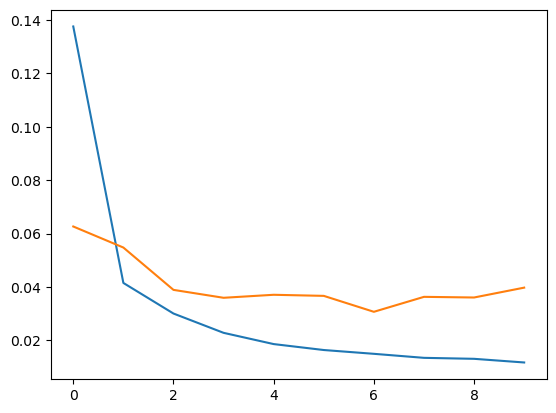

In [9]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [13]:
predicted_signal = model.predict(processor_pipe.X_test)

82/82 [==============================] - 0s 1ms/step


<Axes: xlabel='day', ylabel='true_avoid_ratio'>

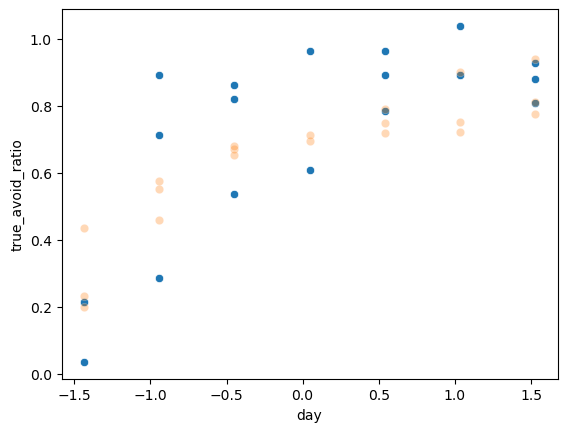

In [17]:
num_cols = processor_pipe.processor.named_transformers_["num"].get_feature_names_out().tolist()
cat_cols = processor_pipe.processor.named_transformers_["cat"].get_feature_names_out().tolist()
cols = num_cols + cat_cols

testing_df = (pd.DataFrame(processor_pipe.X_test, columns=cols)
              .assign(predicted_avoid_ratio = predicted_signal, 
                      true_avoid_ratio = processor_pipe.y_test.values.reshape(-1,1)
                      )
)
dopamine = testing_df.query("sensor_DA ==1").drop(columns = ["sex_M"]).drop_duplicates(subset = ["mouse_id", "day"])
sns.scatterplot(data=dopamine, x="day", y="true_avoid_ratio")
sns.scatterplot(data=dopamine, x="day", y="predicted_avoid_ratio", alpha=0.3)

In [18]:
testing_df

,mouse_id,day,signal_max,signal_min,sensor_D1,sensor_D2,sensor_DA,sex_F,sex_M,predicted_avoid_ratio,true_avoid_ratio
0,-0.230806,-1.435297,-0.315324,0.160673,1.0,0.0,0.0,0.0,1.0,0.232309,0.035714
1,-0.230806,-1.435297,0.488197,-0.097494,0.0,0.0,1.0,0.0,1.0,0.199767,0.035714
2,-0.230806,-1.435297,0.143361,-0.221332,1.0,0.0,0.0,0.0,1.0,0.224795,0.035714
3,-0.230806,-1.435297,3.621173,-0.252239,0.0,0.0,1.0,0.0,1.0,0.373585,0.035714
4,-0.230806,-1.435297,0.966162,1.119450,1.0,0.0,0.0,0.0,1.0,0.220474,0.035714
...,...,...,...,...,...,...,...,...,...,...,...
2618,1.615772,1.525890,0.556783,0.054046,0.0,0.0,1.0,1.0,0.0,0.918386,0.928571
2619,1.615772,1.525890,-1.296870,-0.477033,0.0,1.0,0.0,1.0,0.0,0.810485,0.928571
2620,1.615772,1.525890,-0.532616,-2.636332,0.0,0.0,1.0,1.0,0.0,0.960208,0.928571
2621,1.615772,1.525890,-1.096782,-0.474686,0.0,1.0,0.0,1.0,0.0,0.820321,0.928571


In [59]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth = 6, learning_rate = 0.1, eval_metric='rmse')
xgb_model.fit(processor_pipe.X_train, processor_pipe.y_train, eval_set = [(processor_pipe.X_dev, processor_pipe.y_dev)])
xg_pred = xgb_model.predict(processor_pipe.X_test)
# xgb.score(processor_pipe.X_test, processor_pipe.y_test)


[0]	validation_0-rmse:0.19440
[1]	validation_0-rmse:0.18833
[2]	validation_0-rmse:0.18636
[3]	validation_0-rmse:0.18900
[4]	validation_0-rmse:0.19213
[5]	validation_0-rmse:0.19831
[6]	validation_0-rmse:0.20462
[7]	validation_0-rmse:0.21159
[8]	validation_0-rmse:0.21847
[9]	validation_0-rmse:0.22564
[10]	validation_0-rmse:0.23227
[11]	validation_0-rmse:0.23793
[12]	validation_0-rmse:0.24341
[13]	validation_0-rmse:0.24845
[14]	validation_0-rmse:0.25345
[15]	validation_0-rmse:0.25826
[16]	validation_0-rmse:0.26208
[17]	validation_0-rmse:0.26658
[18]	validation_0-rmse:0.27003
[19]	validation_0-rmse:0.27320
[20]	validation_0-rmse:0.27622
[21]	validation_0-rmse:0.27906
[22]	validation_0-rmse:0.28154
[23]	validation_0-rmse:0.28400
[24]	validation_0-rmse:0.28534
[25]	validation_0-rmse:0.28631
[26]	validation_0-rmse:0.28837
[27]	validation_0-rmse:0.28983
[28]	validation_0-rmse:0.29070
[29]	validation_0-rmse:0.29212
[30]	validation_0-rmse:0.29323
[31]	validation_0-rmse:0.29417
[32]	validation_0-

<Axes: xlabel='day', ylabel='true_avoid_ratio'>

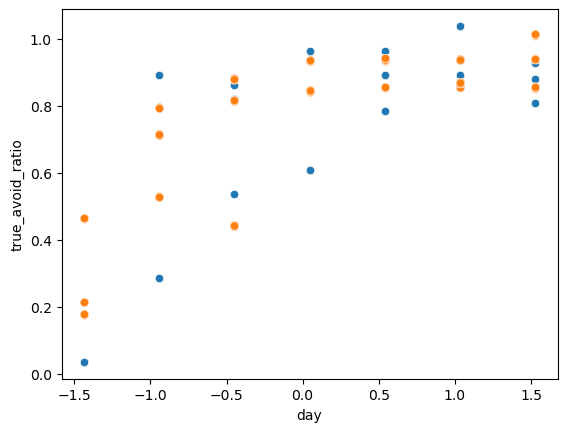

In [44]:
testing_df = testing_df.assign(xg_pred_avoid_ratio = xg_pred)
dopamine = testing_df.query("sensor_DA ==1").drop(columns = ["sex_M"]).drop_duplicates(subset = ["mouse_id", "day"])
sns.scatterplot(data=testing_df, x="day", y="true_avoid_ratio")


sns.scatterplot(data=testing_df, x="day", y="xg_pred_avoid_ratio", alpha=0.3)

In [52]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [61]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    
}
trials = Trials()
def obejective(params):
    max_depth = params['max_depth']
    n_estimators = params['n_estimators']
    learning_rate = params['learning_rate']
    min_child_weight = params['min_child_weight']
    
    xg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, max_depth = max_depth, learning_rate = learning_rate, min_child_weight = min_child_weight, eval_metric='mse')
    model = xg_model.fit(processor_pipe.X_train, processor_pipe.y_train)
    return mean_squared_error(processor_pipe.y_test, model.predict(processor_pipe.X_test))

fmin(obejective, space, algo=tpe.suggest, max_evals=100, trials=trials)



  0%|                                                                                                             | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: 'float' object cannot be interpreted as an integer



  0%|                                                                                                             | 0/100 [00:00<?, ?trial/s, best loss=?]


TypeError: 'float' object cannot be interpreted as an integer